# Computer Vision - P3

### **Carefully read the file `README.md` as well as the following instructions before start coding.**

## Delivery

Up to **1 point out of 10** will be penalized if the following requirements are not fulfilled:

- Implemented code should be commented.

- The questions introduced in the exercises must be answered.

- Add title to the figures to explain what is displayed.

- Comments need to be in **english**.

- The deliverable must be a file named **P3_Student1_Student2.zip** that includes:
    - The notebook P3_Student1_Student2.ipynb completed with the solutions to the exercises and their corresponding comments.
    - All the images used in this notebook.

**Deadline (Campus Virtual): October 30th, 23:00 h** 

==============================================================================================
## Practicum 3: Image and Video Segmentation

==============================================================================================

The main topics are:

1)	Segmentation of video shots with static scenes.

2) Background substraction.

3)	Segmentation of images.

In order to successfuly complete this practicum it is necessary to understand the following theory concepts: background substraction, K-means clustering, etc.

The following chapters of the book “Computer Vision: Algorithms and Applicatons” from Richard Szeliski have further information about the topic:

* Chapter 4: Computer Vision: Algorithms and Applications.

* Chapter 5: Segmentation.

## 3.1 Background substraction methods


Given the video stored in ‘Barcelona-sequence’, which contains images acquired by a static camera, remove all the "artifacts" considered as foreground related to movement extracting the background images.

Note: One of the applications of these methods is the button "remove tourists" implemented in most commercial photo cameras. For instance, Adobe uses the "Monument Mode", which automatically deletes the people going by the cameras.

Read and visualize the sequence of images "images/Barcelona-sequence"
Hint: In order to read a  collection of images, we wil use the function animation.FuncAnimation [https://matplotlib.org/2.0.0/api/_as_gen/matplotlib.animation.FuncAnimation.html].

Observe in the following example, how FuncAnimation is used to read and visualize a sequence of frames. Explore the parameters of animation.FuncAnimation().

<IPython.core.display.Javascript object>


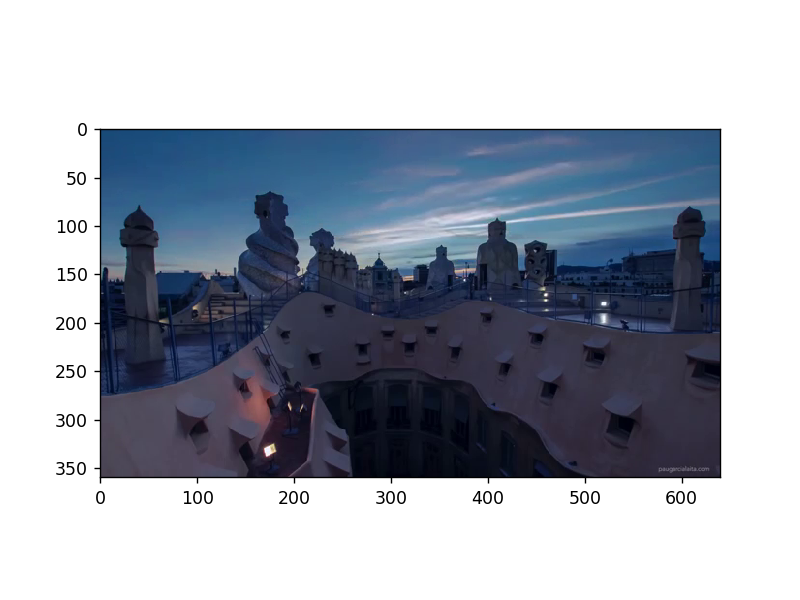

In [1]:
import numpy as np
import skimage
from skimage import io
import matplotlib.pyplot as plt
from skimage import img_as_float, color , exposure

ic = io.ImageCollection('images/Barcelona-sequence/*.png')
        # Reading a sequence of images from a folder

import matplotlib.animation as animation
%matplotlib nbagg 
    #Changing the pluggin is necessary always when visualizing a video!

    
c = 0
i=0      #Inicializing the video display
fig = plt.figure()  # Create figure
im = plt.imshow(ic[i], animated=True) #Visualize the first image

def updatefig1(i):   #Updating the frame visualization
    #c+=1
    #print (c)
    im.set_array(ic[i*5]) #Changing the content of the canvas
    return im, #to return a tuple!

ani = animation.FuncAnimation(fig, updatefig1, interval=5, blit=False, frames=50, repeat= False)


(2 points) a) Find where a shot (scene) finishes and the following starts (boundaries). Each of the scenes in a video is usually called 'shot'. 

To solve this exercise, you need to create a **temporal plot** showing a frame by frame measure to be defined by you, being applicable to distinguish the shots. 

Execute the following code in "Example A". This created **temporal plot** should replace the temporal plot given as a template. 


**Hint:**
- If you need to convert the image to float, the command is: img_as_float()

- If you need the histogram, it is in skimage.exposure


In [2]:
def values_histogram_RGB(image):
    
    image = img_as_float(image)
    y1_r = np.asarray(exposure.histogram(image[:,:,0],nbins=8))[0]
    y1_g = np.asarray(exposure.histogram(image[:,:,1],nbins=8))[0]
    y1_b = np.asarray(exposure.histogram(image[:,:,2],nbins=8))[0]
    
    return np.asarray([y1_r,y1_g,y1_b])

<IPython.core.display.Javascript object>


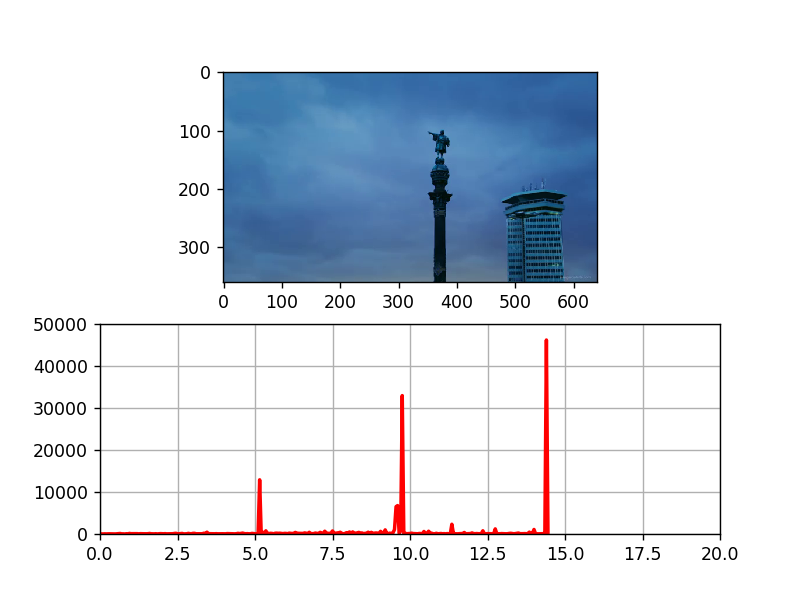

In [3]:
# Example A
# Sinusoidal plot points generation

g = [0]
def data_gen():
    t = data_gen.t
    #g = []
    cnt = 0
    y_prev = 0
    while cnt < 1000:
        image = ic[cnt+1]
        values_next_image = values_histogram_RGB(image)
        
        image1 = ic[cnt]
        values_actual_image = values_histogram_RGB(image1)
        
        values = np.abs(values_next_image - values_actual_image)
        
        y = np.mean(values)
        if y > 10000:
            g.append(cnt)
            g.append(cnt+1)            
        cnt+=1
        t += 0.05
        y_prev = y
        
        # adapted the data generator to yield both sin and cos
        yield t, y

data_gen.t = 0

%matplotlib nbagg

# create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(2,1)

# intialize a line object on the second axes for plotting
line, = ax2.plot([], [], lw=2, color='r')

ax2.set_ylim(0, 50000)
ax2.set_xlim(0, 20)
ax2.grid()

# initialize the data arrays 
xdata, ydata = [], []
def run(data):
    # update the data plot
    t, y = data
    xdata.append(t) # time = x axis
    ydata.append(y) # y axis

    # Plot image on top row
    ax1.imshow(ic[len(xdata)])
          
    # Plot sin in bottom row
    xmin, xmax = ax2.get_xlim()
    if t >= xmax:
        ax2.set_xlim(xmin, 2*xmax)
        ax2.figure.canvas.draw()
            
    # update the data of both line objects
    line.set_data(xdata, ydata)

    return line

ani = animation.FuncAnimation(fig, run, data_gen, blit=True, interval=1, repeat=False)
plt.show()

(0.5 points) b) Show the initial and final images of each shot extracted as follows:

<img src="images_for_notebook/result_shot_detection.png">


<IPython.core.display.Javascript object>


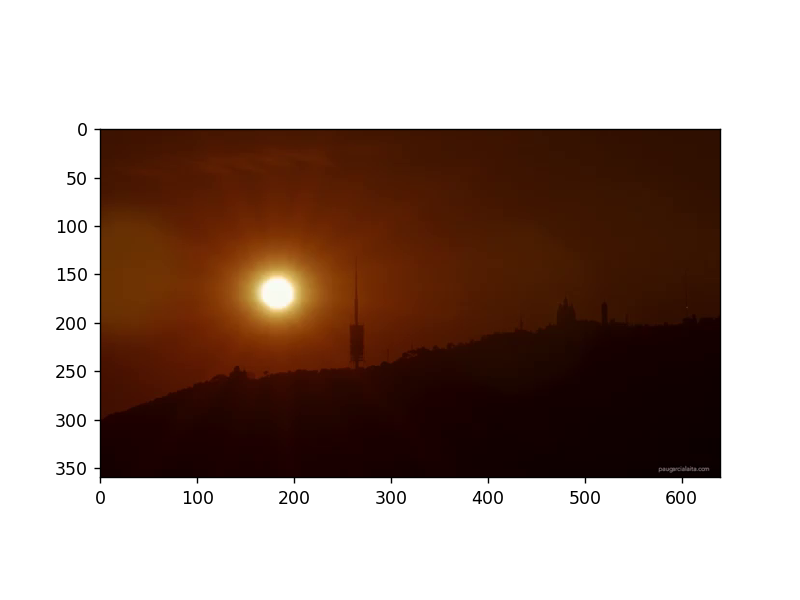

<IPython.core.display.Javascript object>


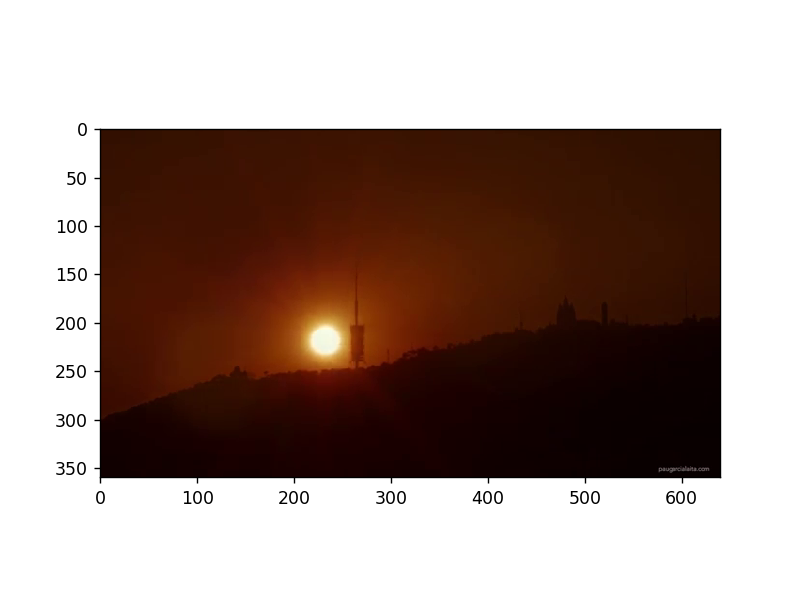

<IPython.core.display.Javascript object>


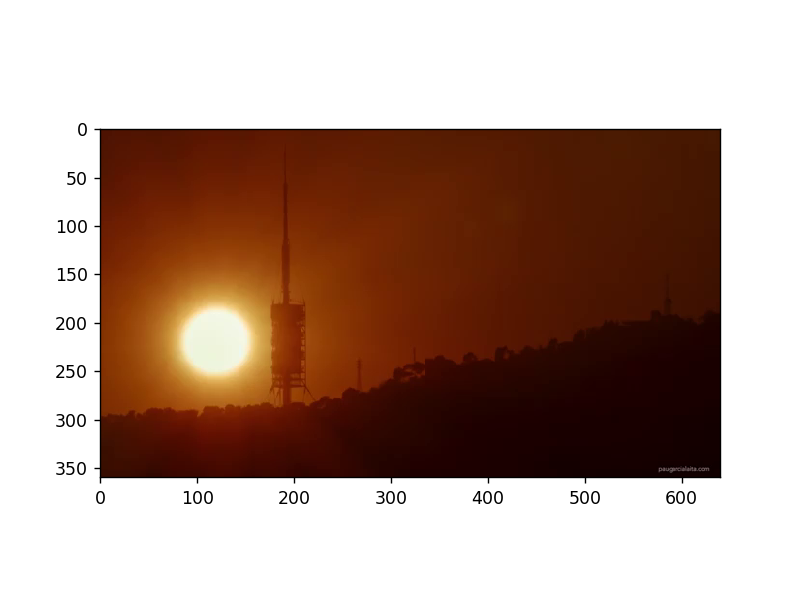

<IPython.core.display.Javascript object>


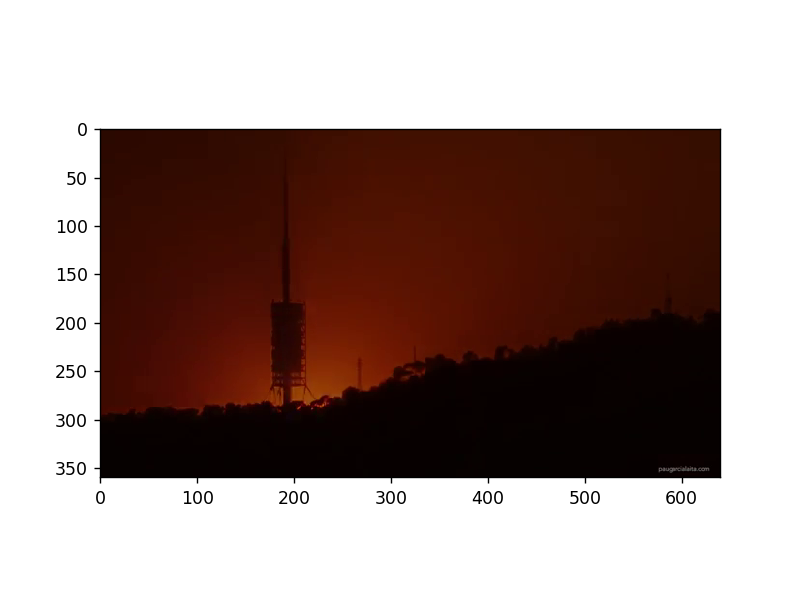

<IPython.core.display.Javascript object>


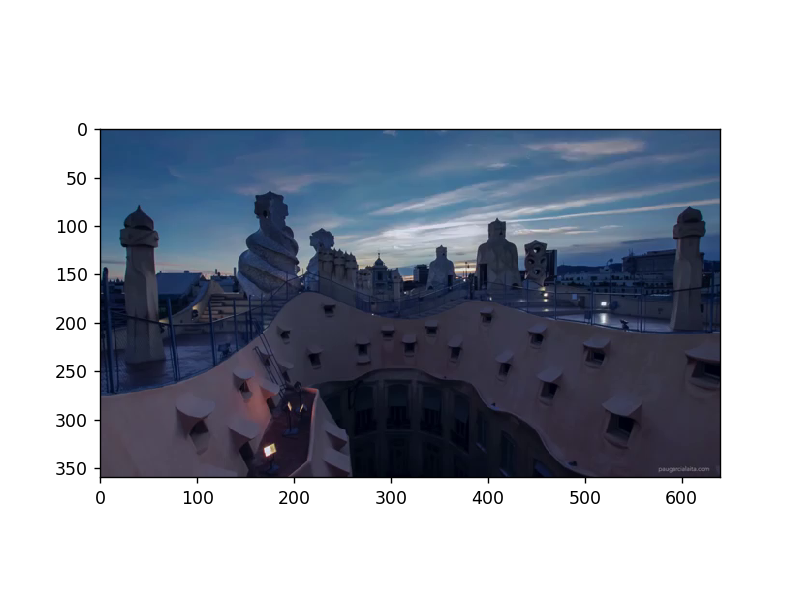

<IPython.core.display.Javascript object>


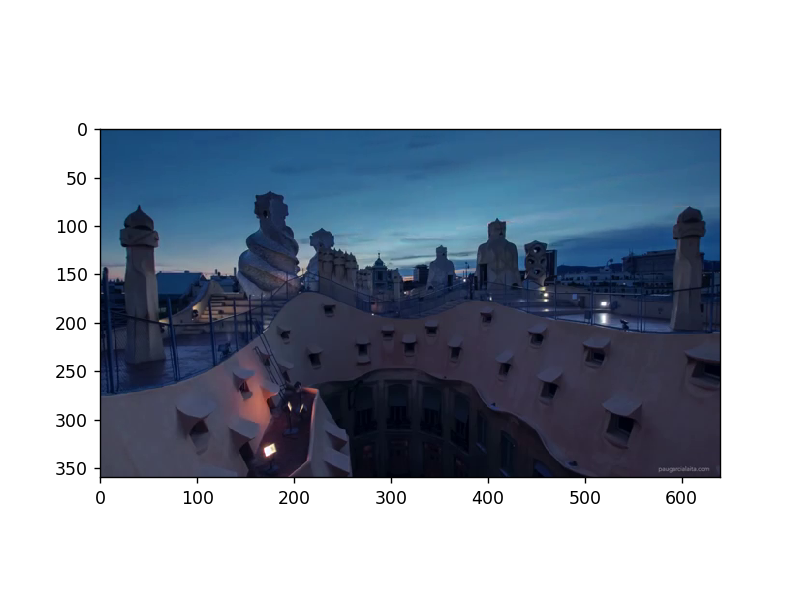

<IPython.core.display.Javascript object>


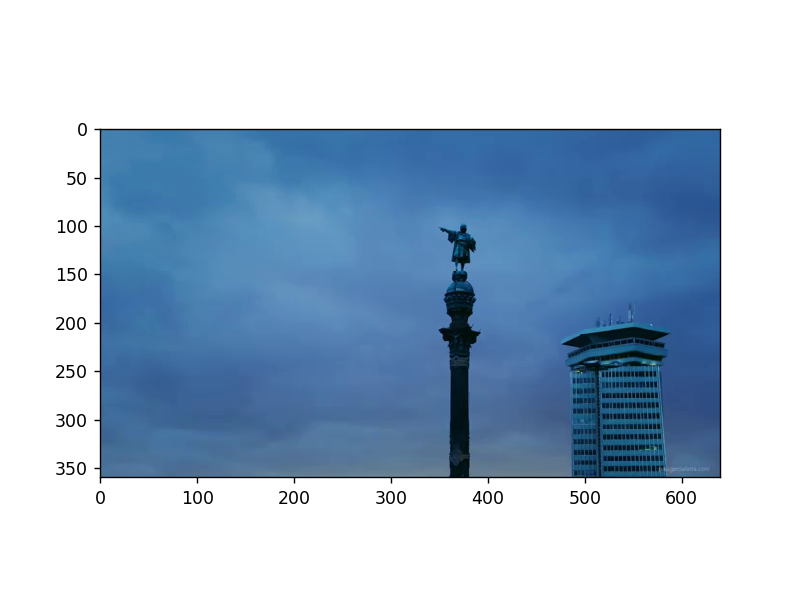

In [4]:
for i in g:
    fig = plt.figure()
    im = plt.imshow(ic[i],animated = True)
    plt.show()

(0.5 points) c) Which measure have you used in order to visually distinguish the shots in a plot? Explain your solution.

## 3.2 Background substraction

(2) a) Apply the background substraction algorithm (check theory material).

Visualize, for each different scene (there are 3) of the video:

    1) images belonging to the shot
    2) the background image, and
    3) the foreground.
    
**Hint**: You can construct a mask obtained from the original image and the background in order to know which parts of the image form part from the foreground and recover from the original image just the foreground regions.

In [5]:
def all_backgrounds():
    half = len(g)
    backgrounds = []
    for a in range(0,half-1,2):
        all_pictures=[]
        for i in range(g[a],g[a+1]):
            all_pictures.append(ic[i])

        background = np.median(all_pictures,axis=0)
        background = np.asarray(background,dtype=np.uint8)
        backgrounds.append(background)
    return backgrounds

In [6]:
#[0, 102, 103, 194, 195, 287, 288]

def show_backgrounds():
    
    f, axarr = plt.subplots(nrows=3,figsize=(10,10))
    backgrounds = all_backgrounds()
    for index in range(len(backgrounds)):
        axarr[index].imshow(backgrounds[index], cmap='gray')
    plt.show()

<IPython.core.display.Javascript object>


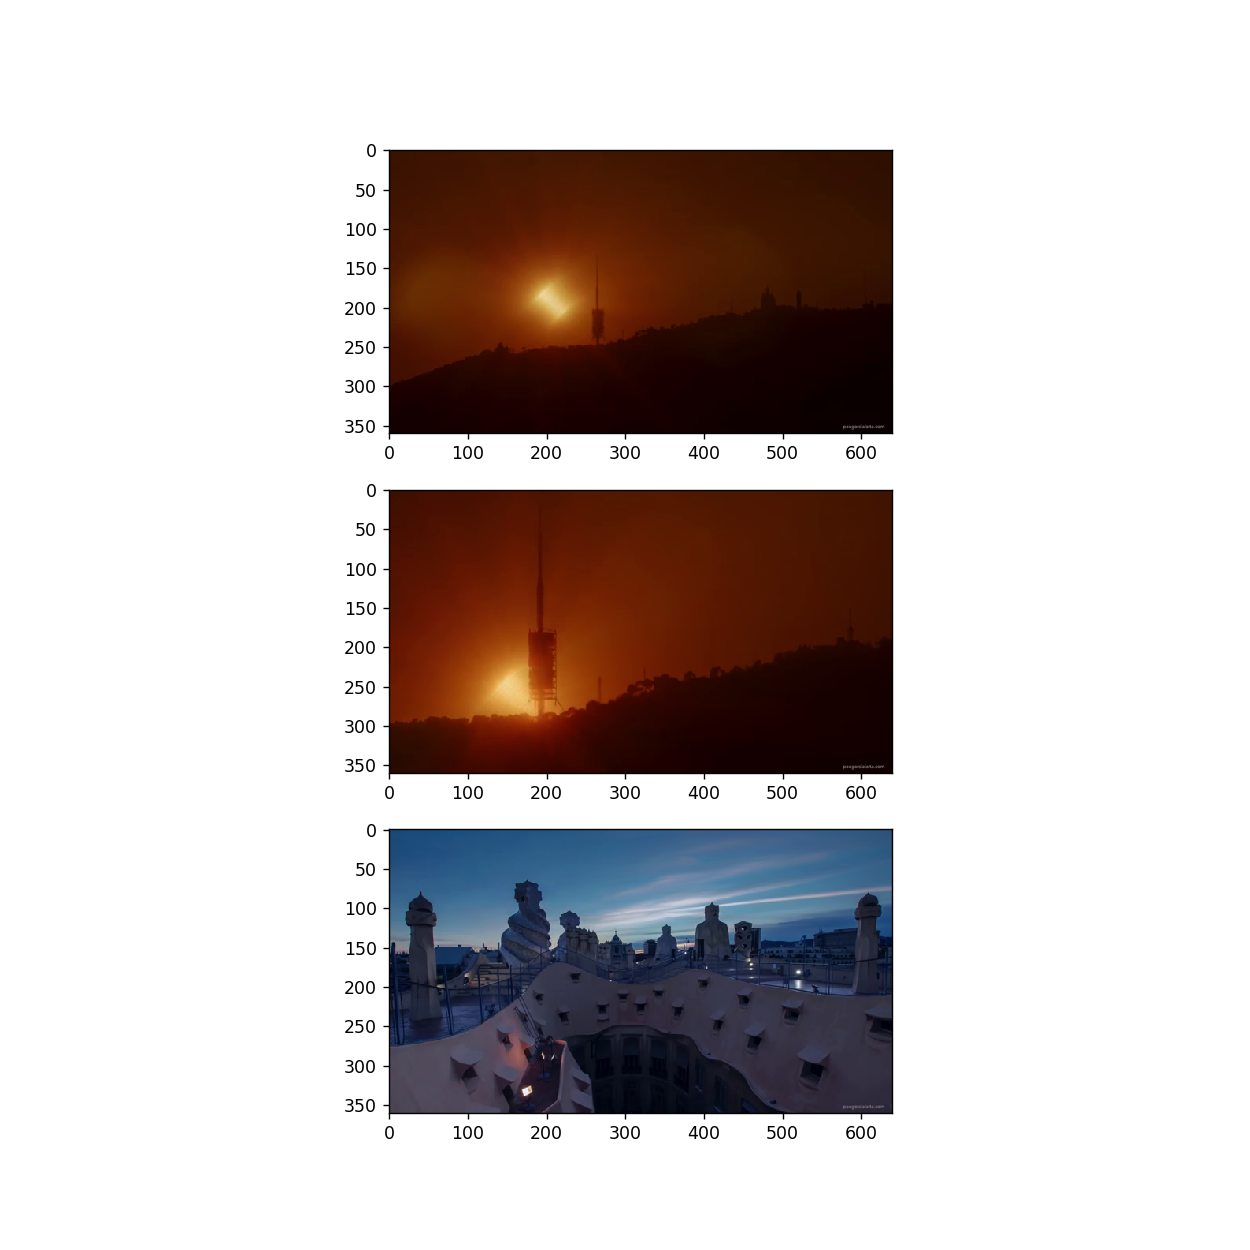

In [7]:
show_backgrounds()

In [8]:
def convert_to_gray():
    half = len(g)
    backgrounds = all_backgrounds()
    grey_backgrounds = []
    grey_original_starts = []
    position_at_image = []
    for picture in backgrounds:
        grey_backgrounds.append(color.rgb2gray(picture))
        
    for index in range(0,half-1,2):
        #print(g[index])
        grey_original_starts.append(color.rgb2gray(ic[g[index]]))  
        position_at_image.append(g[index])
        
        
    return [grey_backgrounds,grey_original_starts,position_at_image]


In [9]:
def show_foreground():
    half = len(g)
    index = 0
    grey_backgrounds, grey_original_starts, values = convert_to_gray()
    grey_backgrounds = np.asarray(grey_backgrounds)
    grey_original_starts = np.asarray(grey_original_starts)    
    
    f, axarr = plt.subplots(nrows=3,figsize=(10,10))
    for index in range(len(grey_backgrounds)):
        axarr[index].imshow(np.abs(grey_backgrounds[index]-grey_original_starts[index]), cmap='gray')
        axarr[index].set_title(str(values[index]))

    plt.show()

<IPython.core.display.Javascript object>


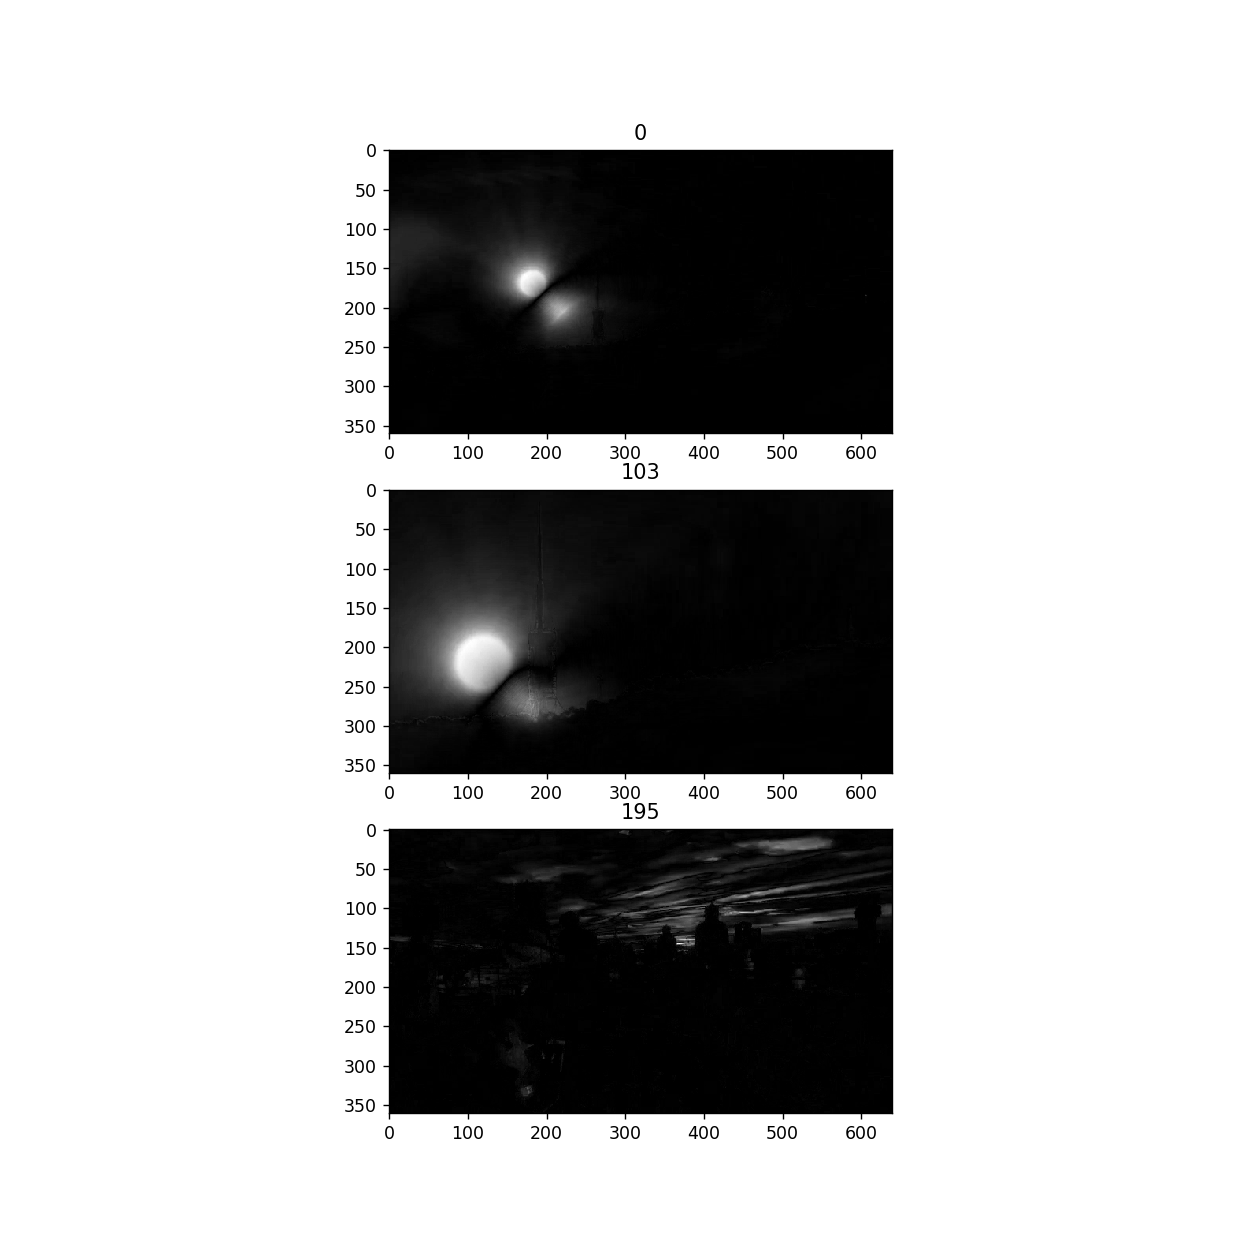

In [10]:
show_foreground()

(0.2 points) - What happens if the shots are not correctly extracted? 



In [ ]:
### If we no extract ths shots corretly it must show 

(0.2 points) - What happens if you find too many shots in the video? 

(0.3 points) - What do the static background images represent? 

(0.2 points) - In which situations does the algorithm work and in which it does not? 


(0.2 points) - What happens if you substract the background image from the original one?

(0.2 points) - Do you see any additional application for this algorithm?

(0.5) **[OPTIONAL]**
Apply the algorithm to some other static video that you found.

## 3.3 Clustering methods on the RGB-XY space

**Hint**: 
- Different image segmentation commands can be found in skimage.segmentation.
- Use the function segmentation.mark_boundaries for seeing the boundaries of the segments.
- Use the inline pluggin to visualize images (%matplotlib inline)

(0.3 points) a) Read any image from the folder 'images' and segment it using Felzenszwalbs's method. 


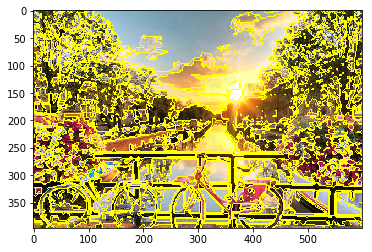

In [11]:
%matplotlib inline
from skimage import segmentation
image = io.imread("images/amsterdam.jpg")
seg = segmentation.felzenszwalb(image, scale=200, sigma=1, min_size=1)
plt.imshow(segmentation.mark_boundaries(image,seg))
plt.show()

(0.5 points) - Test different parameters in order to obtain a good image segmentation.  Which are the optimal values?

In [12]:
#Sigma between of 1, scale big = 100 200 and min_size small 1 ~ 5

(0.3 points) - How does each parameter behave?

(0.2 points) - Comment what algorithm is the method based in up to 3 lines most.

(0.3 points) b) Segment the previous image using SLIC algorithm. 

(0.5 points) - Test different parameters in order to obtain a good image segmentation. Up to your opinion, which are the optimal values? 


(0.3 points) - How does each parameter behave? 


(0.2 points) - Comment what algorithm is the method based in up to 3 lines.

(0.3 points) c) Plot the original image and the results of both algorithms in a 1x3 subplot. 



(0.4 points) d) Calculate also the number of segments obtained on the image by each of the algorithms. 

(0.4 points) e) Comment the differences between each method as well as their advantages and disadvantages.